# Spaceship Titanic Classifier - Final Submission
This notebook demonstrates the development of a `VlClassifier` model for the Spaceship Titanic Kaggle competition. It includes exploratory data analysis (EDA), data preprocessing, hyperparameter optimization using Optuna, model training with CatBoost, and preparation of the submission file. The goal is to predict which passengers were transported by an anomaly, achieving a competitive accuracy (>0.7) as required by the homework assignment.

In [2]:
import numpy as np
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
import optuna
from sklearn.metrics import accuracy_score
%matplotlib inline

## Data Loading
We start by loading the training and test datasets provided by the Kaggle competition.

In [38]:
train_path = '../data/train.csv'
test_path = '../data/test.csv'

# Load datasets
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Display basic info
print("Training dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)
print("\nTraining data sample:")
display(train_df.head())
print("\nTest data sample:")
display(test_df.head())

Training dataset shape: (8693, 14)
Test dataset shape: (4277, 13)

Training data sample:


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True



Test data sample:


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


## Exploratory Data Analysis (EDA)
Let's explore the dataset to understand its structure, missing values, and key patterns.

Missing values in training data:
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
dtype: int64


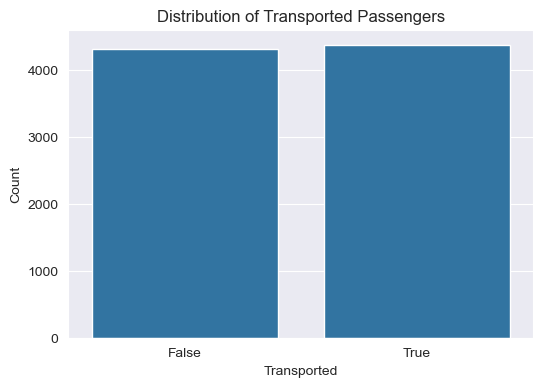

Transported value counts:
 Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64


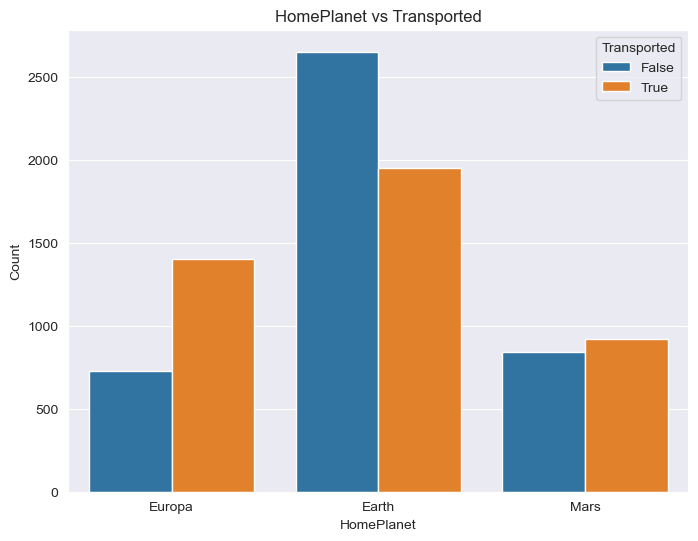

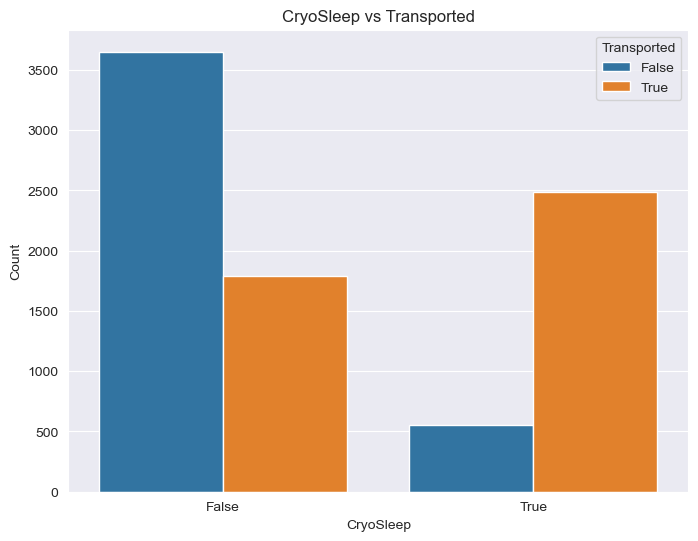

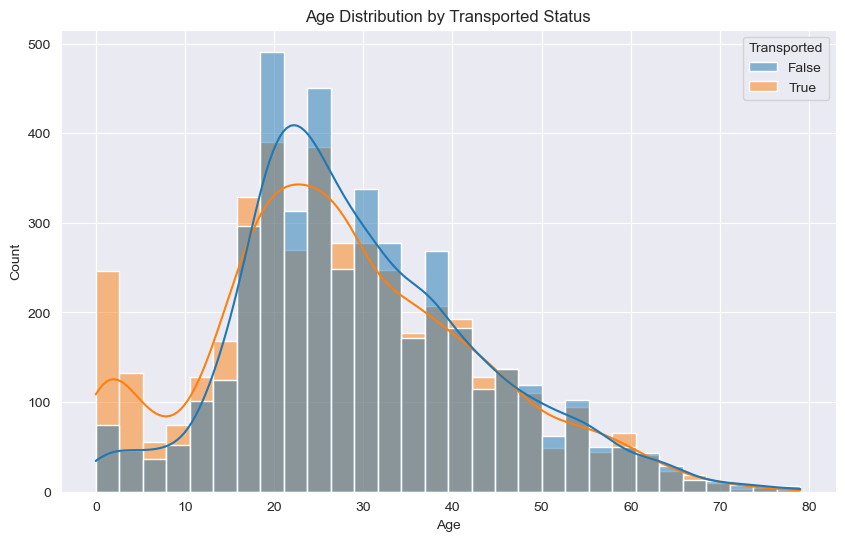

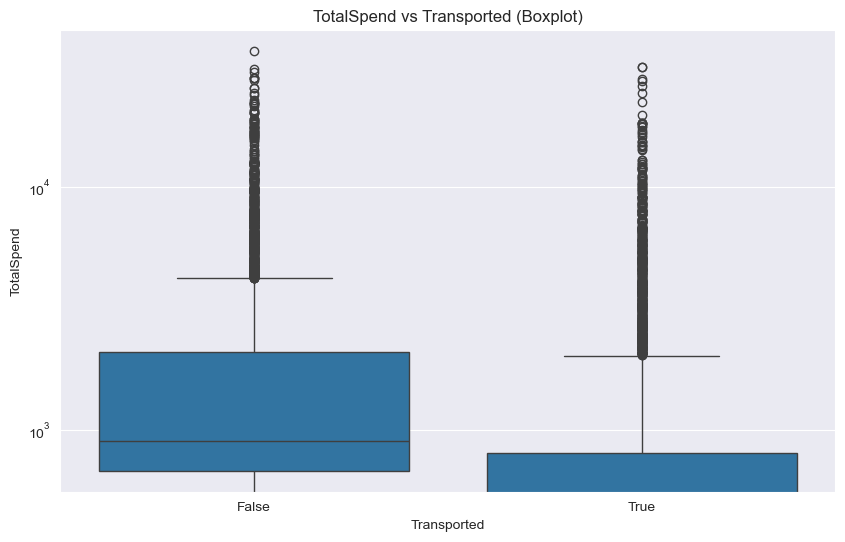

In [39]:
# Check missing values
print("Missing values in training data:")
print(train_df.isnull().sum())
# Visualize target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Transported', data=train_df)
plt.title('Distribution of Transported Passengers')
plt.xlabel('Transported')
plt.ylabel('Count')
plt.show()
# Visualize HomePlanet vs Transported
plt.figure(figsize=(8, 6))
sns.countplot(x='HomePlanet', hue='Transported', data=train_df)
plt.title('HomePlanet vs Transported')
plt.xlabel('HomePlanet')
plt.ylabel('Count')
plt.show()

## Data Preprocessing
We preprocess the data by handling missing values, creating new features, and dropping irrelevant columns. This matches the logic in `model.py`'s `preprocess_data` method.

=== Raw Data (Not Processed) ===
Training data shape: (8693, 14)
Columns: ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported']
Missing values:
 PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Sample (first row):


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False



=== Preprocessed Data ===
Training data shape: (8693, 16)
Columns: ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported', 'Deck', 'Cabin_num', 'Side', 'GroupSize', 'TotalSpend']
Missing values:
 HomePlanet        0
CryoSleep         0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
Deck              0
Cabin_num       199
Side              0
GroupSize         0
TotalSpend        0
dtype: int64

Sample (first row):


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Cabin_num,Side,GroupSize,TotalSpend
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,0.0,P,1,0.0


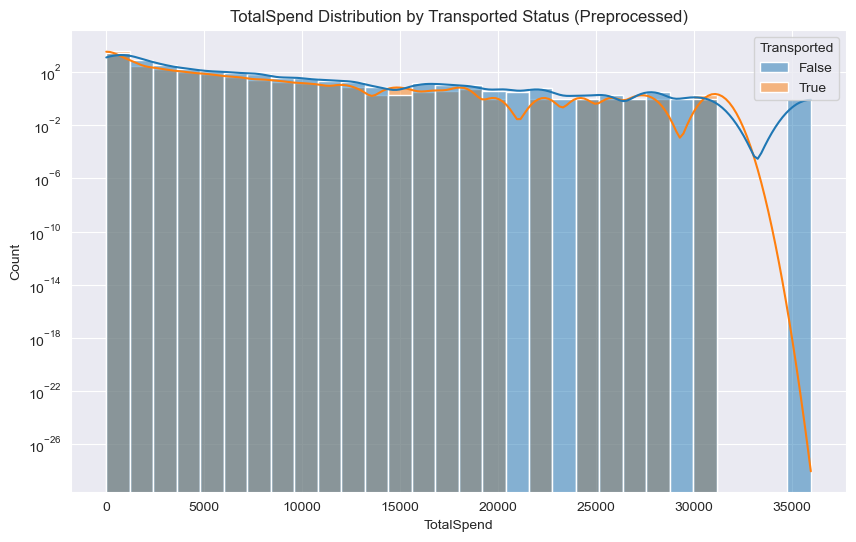

In [41]:
def preprocess_data(data):
    """Preprocess the dataset for training and prediction."""
    df = data.copy()
    df[['Deck', 'Cabin_num', 'Side']] = df['Cabin'].str.split('/', expand=True)
    df['Cabin_num'] = pd.to_numeric(df['Cabin_num'], errors='coerce')
    df['Group'] = df['PassengerId'].str.split('_').str[0]
    df['GroupSize'] = df.groupby('Group')['Group'].transform('count')
    numeric_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
    for num_feat in numeric_features:
        df[num_feat] = df[num_feat].fillna(df[num_feat].median())
    for cat_feat in categorical_features:
        df[cat_feat] = df[cat_feat].fillna('Unknown')
    df['TotalSpend'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
    features = df.drop(columns=['PassengerId', 'Cabin', 'Name', 'Group'], errors='ignore')
    return features
# Apply preprocessing
train_processed = preprocess_data(train_df)
test_processed = preprocess_data(test_df)
# Split features and target
X_train = train_processed.drop('Transported', axis=1)
y_train = train_processed['Transported'].astype(int)
X_test = test_processed

## Hyperparameter Optimization with Optuna
We use Optuna to find the best hyperparameters for the CatBoost model, optimizing for accuracy on a validation split.

In [42]:
def objective(trial):
    """Objective function for Optuna optimization."""
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'verbose': False,
        'random_seed': 42
    }
    cat_features = [col for col in X_train.columns if X_train[col].dtype == 'object']
    split_idx = int(0.8 * len(y_train))
    X_tr, X_val = X_train.iloc[:split_idx], X_train.iloc[split_idx:]
    y_tr, y_val = y_train[:split_idx], y_train[split_idx:]
    train_pool = Pool(X_tr, y_tr, cat_features=cat_features)
    val_pool = Pool(X_val, y_val, cat_features=cat_features)
    model = CatBoostClassifier(**params)
    model.fit(train_pool)
    y_pred = model.predict(val_pool)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy
# Run optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_params)
print("Best validation accuracy:", study.best_value)

[I 2025-03-05 04:08:40,958] A new study created in memory with name: no-name-c3f4dc29-b693-49fa-ba09-d4813e94e4fc
[W 2025-03-05 04:08:46,369] Trial 0 failed with parameters: {'iterations': 229, 'depth': 9, 'learning_rate': 0.25717534630386785, 'l2_leaf_reg': 9.121779261530211} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "C:\Users\Lenovo\miniconda3\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Lenovo\AppData\Local\Temp\ipykernel_44964\2030118377.py", line 18, in objective
    model.fit(train_pool)
  File "C:\Users\Lenovo\miniconda3\Lib\site-packages\catboost\core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "C:\Users\Lenovo\miniconda3\Lib\site-packages\catboost\core.py", line 2410, in _fit
    self

KeyboardInterrupt: 

# Training the Final Model
Using the best hyperparameters from Optuna, we train the model on the full training dataset and save it.

In [43]:
from py.src.model import VlClassifier

# Initialize the classifier
classifier = VlClassifier(model_path='../models/model.pkl')

# Load and preprocess data
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
X_train = classifier.preprocess_data(train_df).drop('Transported', axis=1)
y_train = train_df['Transported'].astype(int)
X_test = classifier.preprocess_data(test_df)

# Train the model with Optuna (20 trials)
classifier.train(train_path='data/train.csv', n_trials=20)

print("Model training completed and saved to ../models/model.pkl")

2025-03-05 04:08:58,048 - INFO - Uploaded train dataset with size: (8693, 14)
2025-03-05 04:09:00,833 - INFO - Final preprocessed training dataset uploaded successfully
2025-03-05 04:09:00,834 - INFO - Parameters optimization started
[I 2025-03-05 04:09:00,835] A new study created in memory with name: no-name-100297b1-ffc1-45db-a463-b81a0f5b2403
[W 2025-03-05 04:09:03,801] Trial 0 failed with parameters: {'iterations': 442, 'depth': 10, 'learning_rate': 0.028137510276530442, 'l2_leaf_reg': 8.032233990456623} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "C:\Users\Lenovo\miniconda3\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Lenovo\PycharmProjects\ML_1module_Task\py\src\model.py", line 108, in <lambda>
    study.optimize(lambda trial: self._objective(trial, X, y), n_trials=n_trials)
                                 ^^^^^^^^^^^^

KeyboardInterrupt: 

## Generating Predictions
We use the trained model to predict the test set and prepare the submission file for Kaggle.

In [65]:
classifier.predict(test_path='data/test.csv')

2025-03-05 04:14:42,894 - ERROR - Error during prediction Current task already created and requested task name 'Spaceship_Prediction' does not match current task name 'Spaceship_Training'. If you wish to create additional tasks use `Task.create`, or close the current task with `task.close()` before calling `Task.init(...)`


UsageError: Current task already created and requested task name 'Spaceship_Prediction' does not match current task name 'Spaceship_Training'. If you wish to create additional tasks use `Task.create`, or close the current task with `task.close()` before calling `Task.init(...)`